In [9]:
%pip install ydata-profiling
%pip install ipywidgets


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Majix\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Majix\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


# Análisis Exploratorio

In [10]:
import pandas as pd
from ydata_profiling import ProfileReport

# Cargar el archivo CSV
df_train = pd.read_csv('data/train.csv')

# Generar el reporte de análisis exploratorio y mostrarlo en el notebook
profile = ProfileReport(df_train, title="Exploratory Data Analysis Report", explorative=True)

# Mostrar el reporte dentro del Jupyter Notebook
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Limpieza de datos

In [11]:
import re
import json
import ast
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Function to clean text by removing stopwords, special characters, and URLs
def limpiar_texto(texto):
    if not texto:
        return ""
    
    texto = texto.lower()
    texto = re.sub(r"[#@']", "", texto)  # Remove hashtags, at-signs, apostrophes
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto, flags=re.MULTILINE)  # Remove URLs
    texto = texto.encode('ascii', 'ignore').decode('ascii')  # Remove non-ASCII characters
    texto = texto.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in word_tokenize(texto) if word not in stop_words]
    
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Majix\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Majix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:

# Function to clean LaTeX text by removing LaTeX formatting
def latex_a_texto(latex):
    if not latex:
        return ""
    
    # Remove LaTeX commands and formatting
    latex = re.sub(r'\\(begin|end)\{itemize\}', '', latex)
    latex = re.sub(r'\\item\s*', '\n', latex)
    latex = re.sub(r'\\[a-zA-Z]+\{[^}]*\}', '', latex)
    latex = re.sub(r'\s+', ' ', latex).strip()
    
    return latex

In [13]:

# Function to convert text to JSON or leave as text if it's not a valid JSON
def convertir_a_lista(texto):
    try:
        return json.loads(texto)
    except json.JSONDecodeError:
        return texto

In [14]:

# Clean prompt, response A, and response B text columns
def limpiar_df(df):
    # Apply cleaning functions to prompts and responses
    df['prompt_limpio'] = df['prompt'].apply(lambda lista: [limpiar_texto(texto) for texto in lista])
    df['response_a_texto'] = df['response_a'].apply(latex_a_texto).apply(convertir_a_lista)
    df['response_b_texto'] = df['response_b'].apply(latex_a_texto).apply(convertir_a_lista)
    df['response_a_limpio'] = df['response_a_texto'].apply(lambda lista: [limpiar_texto(texto) for texto in lista])
    df['response_b_limpio'] = df['response_b_texto'].apply(lambda lista: [limpiar_texto(texto) for texto in lista])

    return df

In [15]:
import nltk
nltk.download('punkt')

df_train = limpiar_df(df_train)


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\Majix/nltk_data'
    - 'C:\\Users\\Majix\\AppData\\Local\\Programs\\Python\\Python312\\nltk_data'
    - 'C:\\Users\\Majix\\AppData\\Local\\Programs\\Python\\Python312\\share\\nltk_data'
    - 'C:\\Users\\Majix\\AppData\\Local\\Programs\\Python\\Python312\\lib\\nltk_data'
    - 'C:\\Users\\Majix\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


Probando leer una conversación entre el usuario y el modelo:

In [ ]:
for i in range(len(df_train["prompt"][0])):
  print(i)
  print(df_train["prompt"][0][i])
  print("\n")
  print(df_train["response_a_texto"][0][i])
  print("\n")
  print(df_train["response_b_texto"][0][i])
  print("\n")

Terminando de limpiar:

In [ ]:
def limpiar_respuestas(df, columnas):
    for columna in columnas:
        df[f'{columna}_limpio'] = df[columna].apply(lambda lista: [limpiar_texto(texto) for texto in lista])
    return df

columnas_a_limpiar = ['response_a_texto', 'response_b_texto']

df_train = limpiar_respuestas(df_train, columnas_a_limpiar)


## Cruce de variables importantes y graficos exploratorios

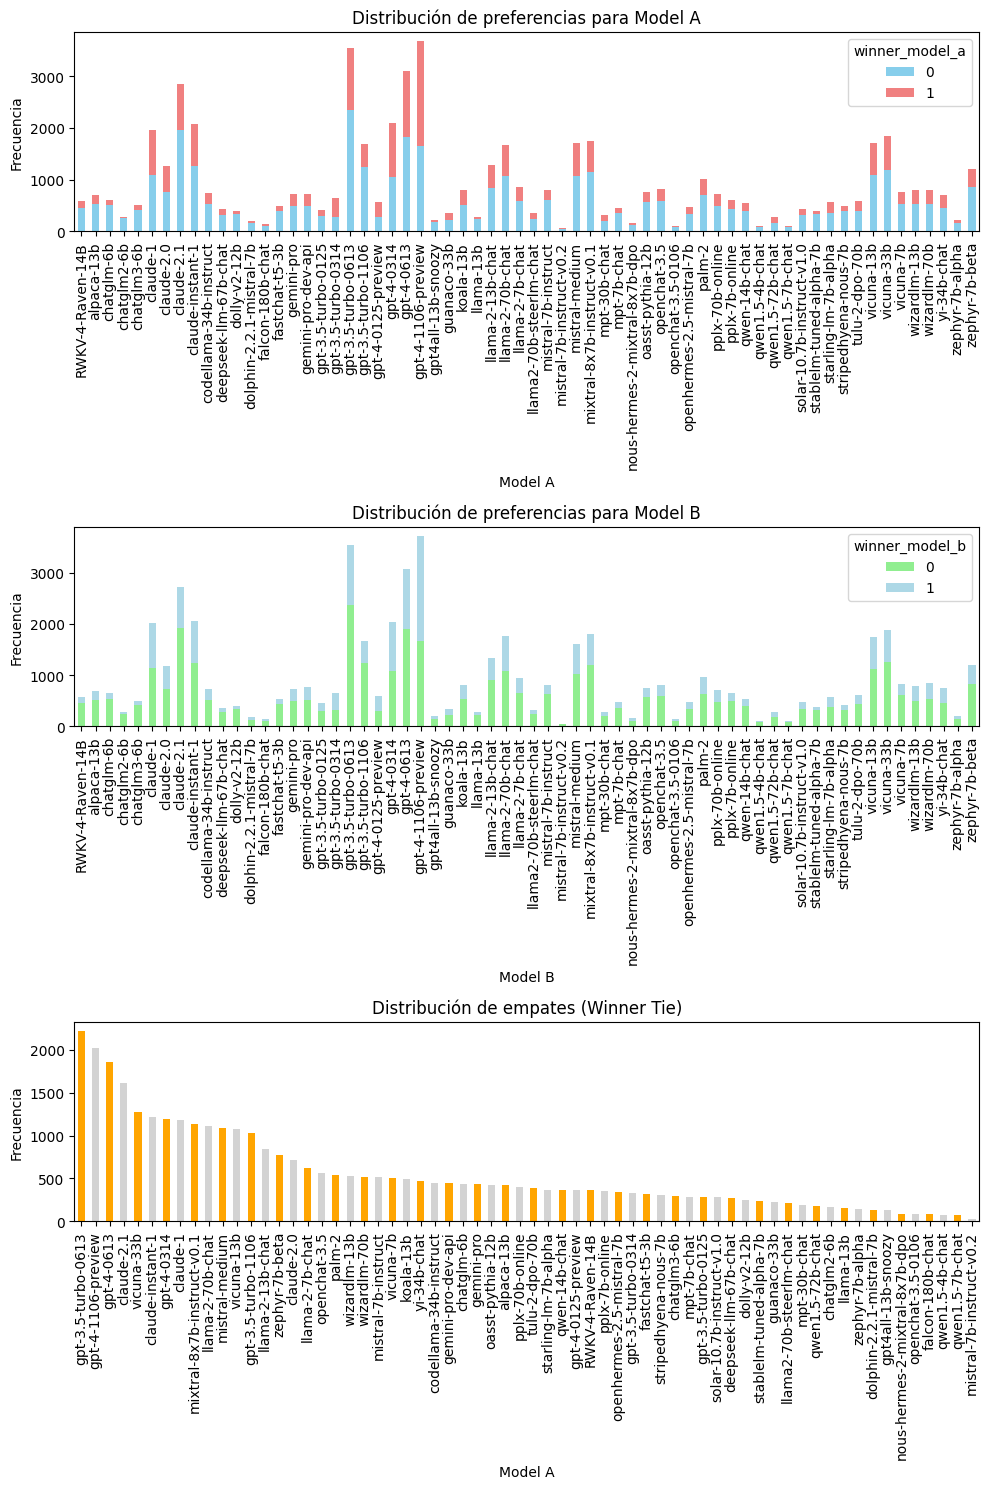

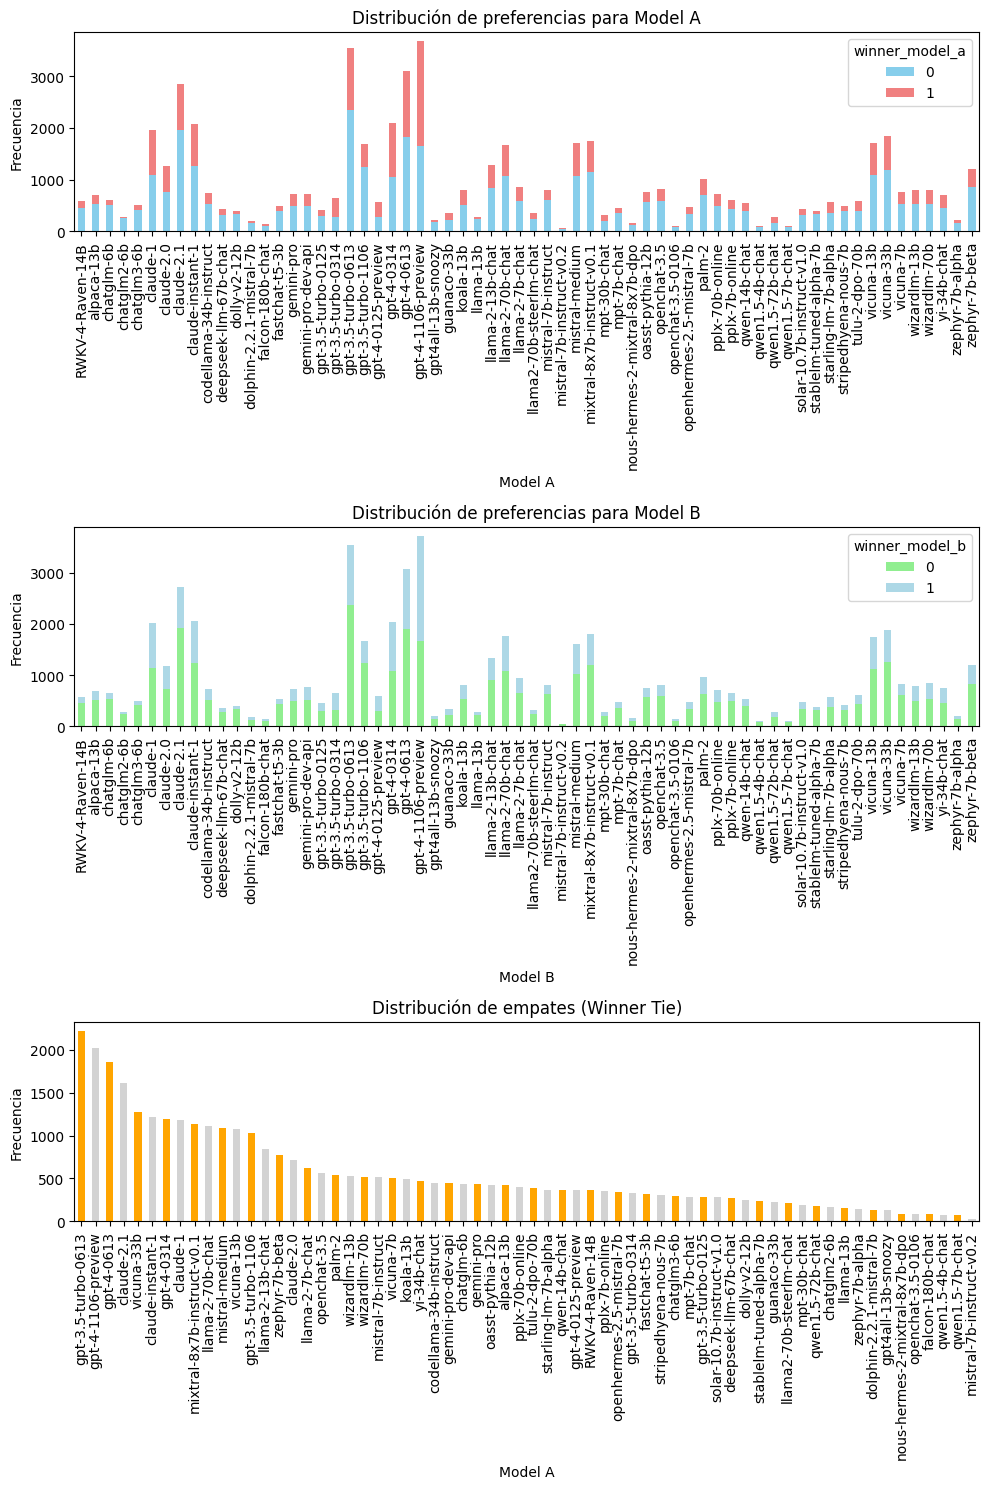

In [18]:
import matplotlib.pyplot as plt
# Enable inline plotting
%matplotlib inline
# Cruce de preferencias con los modelos
cross_a = pd.crosstab(df_train['model_a'], df_train['winner_model_a'])
cross_b = pd.crosstab(df_train['model_b'], df_train['winner_model_b'])
# Concatenar los modelos A y B para evitar duplicados en los empates
all_models_tie = pd.concat([df_train[['model_a', 'winner_tie']],
                            df_train[['model_b', 'winner_tie']].rename(columns={'model_b': 'model_a'})])

# Contar los empates por modelo
tie_counts = all_models_tie[all_models_tie['winner_tie'] == 1]['model_a'].value_counts()

# Gráfico de barras para visualización
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Gráfico para el modelo A
cross_a.plot(kind='bar', stacked=True, ax=axs[0], color=['skyblue', 'lightcoral'])
axs[0].set_title('Distribución de preferencias para Model A')
axs[0].set_xlabel('Model A')
axs[0].set_ylabel('Frecuencia')

# Gráfico para el modelo B
cross_b.plot(kind='bar', stacked=True, ax=axs[1], color=['lightgreen', 'lightblue'])
axs[1].set_title('Distribución de preferencias para Model B')
axs[1].set_xlabel('Model B')
axs[1].set_ylabel('Frecuencia')

# Gráfico para los empates
tie_counts.plot(kind='bar', stacked=True, ax=axs[2], color=['orange', 'lightgrey'])
axs[2].set_title('Distribución de empates (Winner Tie)')
axs[2].set_xlabel('Model A')
axs[2].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


In [ ]:
#Modelos que más veces ganaron en Model A
top_winner_model_a = cross_a.sum(axis=1).sort_values(ascending=False).head()

# Modelos que más veces ganaron en Model B
top_winner_model_b = cross_b.sum(axis=1).sort_values(ascending=False).head()

top_winner_model_a, top_winner_model_b, tie_counts

Los resultados muestran que el modelo gpt-4-1106-preview es consistentemente uno de los más preferidos por los usuarios, con 3678 preferencias en el rol de Model A y 3709 en Model B. Este modelo destaca significativamente en las interacciones, lo que sugiere que sus respuestas son frecuentemente valoradas como las mejores. Le sigue el modelo gpt-3.5-turbo-0613, con un rendimiento igualmente fuerte en ambas posiciones: 3553 preferencias en Model A y 3530 en Model B, lo que lo convierte en un competidor muy robusto.

En cuanto a los empates, gpt-3.5-turbo-0613 lidera con 2217 empates, seguido de cerca por gpt-4-1106-preview con 2027, lo que indica que los usuarios encuentran difícil elegir entre las respuestas de estos dos modelos en muchas ocasiones. Otros modelos relevantes incluyen gpt-4-0613 y claude-2.1, que también reciben una cantidad considerable de preferencias en las tres categorías (Model A, Model B y empates), aunque en menor medida. Por otro lado, modelos como gpt-4-0314 y claude-instant-1 presentan una participación más modesta.

Estos datos sugieren que los modelos GPT, en sus diversas versiones, tienden a dominar en términos de preferencias del usuario, con frecuentes empates entre ellos, lo que resalta la alta calidad y competitividad de sus respuestas.

In [16]:
# Contar cuántas respuestas en total hay de cada modelo en Model A y Model B
model_a_counts = df_train['model_a'].value_counts()
model_b_counts = df_train['model_b'].value_counts()

# Sumar las respuestas de los modelos que aparecen en ambas columnas
total_model_responses = model_a_counts.add(model_b_counts, fill_value=0)

# Ahora sumar las veces que cada modelo aparece en un empate (combinando Model A y Model B)
# Concatenar los modelos para los empates
all_models_tie = pd.concat([df_train[['model_a', 'winner_tie']],
                            df_train[['model_b', 'winner_tie']].rename(columns={'model_b': 'model_a'})])

# Contar los empates por modelo
tie_counts = all_models_tie[all_models_tie['winner_tie'] == 1]['model_a'].value_counts()

# Sumar las veces que cada modelo participó en un empate al conteo total de respuestas
total_model_responses_with_ties = total_model_responses.add(tie_counts, fill_value=0).sort_values(ascending=False)

# Mostrar el total de respuestas por modelo, incluyendo empates
total_model_responses_with_ties.head()


gpt-4-1106-preview    9414
gpt-3.5-turbo-0613    9300
gpt-4-0613            8024
claude-2.1            7197
claude-instant-1      5350
Name: count, dtype: int64

# Análisis del problema

## Situación Problemática
Veamos como en los últimos años ha habido un crecimiento y uso exponencial de los chatbots impulsados por inteligencia artificial. Cada vez más empresas los utilizan para cosas como servicio al cliente, resolución de problemas, ayudar con clases, etc. Esto ha hecho que la demanda para sistemas mejores, más inteligentes, y a la vez más eficientes ha incrementado. Esto entonces nos da paso al problema en cuestión que es, que debemos mejorar las respuestas y el rendimiento de los chatbots, ya que muchas veces sigue siendo necesaria la interacción humana, y los chatbots no son capaces de manejar problemas o situaciones complejas.

## Problema científico
El problema en este caso es de qué manera podemos evaluar y mejorar a los chatbots para que estos elaboren siempre contenido relevante, coherente, que tenga que ver con la situación y el contexto que se le están proveyendo, que suene de forma natural. De modo que de alguna manera debemos ser capaces de comparar y evaluar a estos Chatbots, como en la Chatbot Arena para lograr hacer esto de manera eficiente

## Objetivos
### Objetivo General
Lograr identificar patrones a nivel general que nos indiquen qué tipo de respuestas son las que los usuarios suelen preferir
### Objetivos específicos
- Identificar, si dentro de los chatbots datos existe uno que sea mucho más dominante que los otros
- Diseñar métricas efectivas para poder evaluar las respuestas de los diferentes chatbots y poder así determinar cuál es la preferente por el usuario.
- Utilizar distintas técnicas de Machine Learning para identificar cuál es la más efectiva para realizar las evaluaciones y las predicciones

# Registro de Cambios
